In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import calendar
from dateutil import easter

import spacy
from rapidfuzz import process, fuzz

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("merged_kenya_tweets.csv", encoding='ISO-8859-1')
df.head(10)

,unnamed:_0,likes,retweets,total_replies,created_at,cleaned_text,label
0,0.0,39,2,0,2024-07-30 10:27:22+00:00,former ig japheth koome should be taken to icc...,neutral
1,1.0,0,0,0,2024-07-31 07:12:21+00:00,my views japheth koome should be charged prose...,neutral
2,2.0,5,5,0,2024-07-20 10:43:30+00:00,at this rate we might as well have ig japheth ...,neutral
3,3.0,593,248,114,2024-07-12 18:31:05+00:00,kenyas police chief japhet koome has resigned ...,neutral
4,4.0,6,4,0,2024-09-29 21:45:26+00:00,japheth koomes resignation has resulted in the...,neutral
5,5.0,0,0,0,2024-09-14 12:20:12+00:00,we are very funny creatures we have forgotten ...,offensive
6,6.0,5,0,1,2024-10-25 17:58:27+00:00,japheth koome alienda wapi,neutral
7,7.0,31,10,5,2024-07-15 08:15:13+00:00,azimio leader raila odinga has demanded the pr...,neutral
8,8.0,3,0,1,2024-08-31 14:09:31+00:00,attorney general dorcas oduor says her office ...,neutral
9,9.0,623,207,119,2024-07-14 19:16:09+00:00,jimmy wanjigi will be a guest speaker in x spa...,neutral


In [3]:
df.tail(10)

,unnamed:_0,likes,retweets,total_replies,created_at,cleaned_text,label
10961,NaN,15,8,1,2025-04-12 20:31:41+00:00,zimeshika kama dress ya millicent omanga,offensive
10962,NaN,8,5,1,2025-04-18 21:48:33+00:00,zimeshika kama pandi ya omanga,offensive
10963,NaN,14,7,1,2025-04-20 22:42:23+00:00,zimeshika kama thong ya millicent omanga,offensive
10964,NaN,6,6,1,2025-04-20 00:49:12+00:00,zimeshika kama thong ya omanga adi sioni simu ...,offensive
10965,NaN,41,25,0,2025-04-18 20:45:21+00:00,zimeshika kama thong ya omanga gadamn,offensive
10966,NaN,32,29,0,2025-04-11 19:01:31+00:00,zimeshika kuliko kata mafi ya omanga gadamn,offensive
10967,NaN,3,2,0,2025-04-13 02:01:10+00:00,zimeshika kuliko thong ya omanga,offensive
10968,NaN,0,0,0,2025-04-15 20:55:03+00:00,zinashika kama laana ya raila ama mkuu,offensive
10969,NaN,6,3,0,2024-10-09 02:22:10+00:00,zitamaliza salasya,neutral
10970,NaN,18,9,1,2025-04-19 22:28:15+00:00,zitashika kama panty ya millicent omanga,offensive


In [4]:
df.columns

Index(['unnamed:_0', 'likes', 'retweets', 'total_replies', 'created_at',
       'cleaned_text', 'label'],
      dtype='object')

In [5]:
df.shape

(10971, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10971 entries, 0 to 10970
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   unnamed:_0     2251 non-null   float64
 1   likes          10971 non-null  int64  
 2   retweets       10971 non-null  int64  
 3   total_replies  10971 non-null  int64  
 4   created_at     10971 non-null  object 
 5   cleaned_text   10959 non-null  object 
 6   label          10971 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 600.1+ KB


In [7]:
df.duplicated().sum()

780

In [8]:
df.isnull().sum()

unnamed:_0       8720
likes               0
retweets            0
total_replies       0
created_at          0
cleaned_text       12
label               0
dtype: int64

In [9]:
# Categorical summary only (object, category, etc.)
categorical_summary = df.describe(include=['object']).T

In [10]:
# Numeric summary only
numeric_summary = df.describe(include=[float, int]).T

# 3. Data Preparation

## 3.1. Data Cleaning

In [11]:
# Convert to numeric columns
df['likes'] = pd.to_numeric(df['likes'], errors='coerce')
df['retweets'] = pd.to_numeric(df['retweets'], errors='coerce')
df['total_replies'] = pd.to_numeric(df['total_replies'], errors='coerce')

# Convert date column
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

In [12]:
# Convert to categorical columns
df['cleaned_text'] = df['cleaned_text'].astype('category')
df['label'] = df['label'].astype('category')

In [13]:
# Dropping unwanted column
df = df.drop(columns=['unnamed:_0'])

In [14]:
# checking columns sfter dropping a column
df_columns = df.columns
print(df_columns)

Index(['likes', 'retweets', 'total_replies', 'created_at', 'cleaned_text',
       'label'],
      dtype='object')


In [15]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

In [16]:
# Checking the first few rows of the dataset again
df.head(10)

,likes,retweets,total_replies,created_at,cleaned_text,label
0,39,2,0,2024-07-30 10:27:22+00:00,former ig japheth koome should be taken to icc...,neutral
1,0,0,0,2024-07-31 07:12:21+00:00,my views japheth koome should be charged prose...,neutral
2,5,5,0,2024-07-20 10:43:30+00:00,at this rate we might as well have ig japheth ...,neutral
3,593,248,114,2024-07-12 18:31:05+00:00,kenyas police chief japhet koome has resigned ...,neutral
4,6,4,0,2024-09-29 21:45:26+00:00,japheth koomes resignation has resulted in the...,neutral
5,0,0,0,2024-09-14 12:20:12+00:00,we are very funny creatures we have forgotten ...,offensive
6,5,0,1,2024-10-25 17:58:27+00:00,japheth koome alienda wapi,neutral
7,31,10,5,2024-07-15 08:15:13+00:00,azimio leader raila odinga has demanded the pr...,neutral
8,3,0,1,2024-08-31 14:09:31+00:00,attorney general dorcas oduor says her office ...,neutral
9,623,207,119,2024-07-14 19:16:09+00:00,jimmy wanjigi will be a guest speaker in x spa...,neutral


In [17]:
# Checking duplicates after dropping
df.duplicated().sum()

0

In [18]:
# checking shapes
df.shape

(9664, 6)

In [19]:
# Apply .lower() to every string cell in the DataFrame
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df.head()

,likes,retweets,total_replies,created_at,cleaned_text,label
0,39,2,0,2024-07-30 10:27:22+00:00,former ig japheth koome should be taken to icc...,neutral
1,0,0,0,2024-07-31 07:12:21+00:00,my views japheth koome should be charged prose...,neutral
2,5,5,0,2024-07-20 10:43:30+00:00,at this rate we might as well have ig japheth ...,neutral
3,593,248,114,2024-07-12 18:31:05+00:00,kenyas police chief japhet koome has resigned ...,neutral
4,6,4,0,2024-09-29 21:45:26+00:00,japheth koomes resignation has resulted in the...,neutral


In [20]:
df['label'].value_counts()

label
neutral      5816
hate         1941
offensive    1907
Name: count, dtype: int64

## 3.2.  Feature Engineering

Feature engineering is a critical step in preparing the dataset for analysis and modeling. It involves creating new features that better represent the underlying patterns in the data. Below are the engineered features and the reasoning behind their inclusion:

### Columns Used for Feature Engineering

- **likes**, **retweets**, **total_replies**
  - These three metrics reflect user engagement with a tweet. Individually, they are important, but combined, they can offer a more comprehensive view.

- **cleaned_text**
  - The cleaned tweet content is used to extract linguistic features like length, word count, hashtags, and mentions, which help understand the structure and purpose of a tweet.

- **created_at**
  - This datetime field is used to derive time-based patterns, such as when a politician is trending or how tweet activity varies by season, hour, or weekday.

---

### New Features Created

- **engagement_score** = likes + retweets + total_replies  
  → A unified metric to measure tweet popularity or user response.

- **tweet_length**  
  → Total number of characters in a tweet. Longer tweets may carry more detail or stronger sentiment.

- **word_count**  
  → Number of words in a tweet. Helps analyze verbosity or messaging style.

- **hour**, **day**, **month**, **year**, **day_of_week**, **season**  
  → Helps analyze temporal trends in tweet activity and engagement, including political events or public sentiment surges.

---

These engineered features help improve the interpretability of the dataset and enhance the performance.


### 1. Engagement Score (likes, retweets, and replies)

In [21]:
df['engagement_score'] = df['likes'] + df['retweets'] + df['total_replies']

### 2. Tweet Length (number of characters)

In [22]:
df['tweet_length'] = df['cleaned_text'].apply(len)
df['tweet_length'].head(5)

0     74.0
1    120.0
2    104.0
3    246.0
4    273.0
Name: tweet_length, dtype: float64

### 3. Word Count

In [23]:
df['word_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
df.head(10)

,likes,retweets,total_replies,created_at,cleaned_text,label,engagement_score,tweet_length,word_count
0,39,2,0,2024-07-30 10:27:22+00:00,former ig japheth koome should be taken to icc...,neutral,41,74.0,13.0
1,0,0,0,2024-07-31 07:12:21+00:00,my views japheth koome should be charged prose...,neutral,0,120.0,18.0
2,5,5,0,2024-07-20 10:43:30+00:00,at this rate we might as well have ig japheth ...,neutral,10,104.0,19.0
3,593,248,114,2024-07-12 18:31:05+00:00,kenyas police chief japhet koome has resigned ...,neutral,955,246.0,37.0
4,6,4,0,2024-09-29 21:45:26+00:00,japheth koomes resignation has resulted in the...,neutral,10,273.0,43.0
5,0,0,0,2024-09-14 12:20:12+00:00,we are very funny creatures we have forgotten ...,offensive,0,239.0,39.0
6,5,0,1,2024-10-25 17:58:27+00:00,japheth koome alienda wapi,neutral,6,26.0,4.0
7,31,10,5,2024-07-15 08:15:13+00:00,azimio leader raila odinga has demanded the pr...,neutral,46,236.0,34.0
8,3,0,1,2024-08-31 14:09:31+00:00,attorney general dorcas oduor says her office ...,neutral,4,271.0,41.0
9,623,207,119,2024-07-14 19:16:09+00:00,jimmy wanjigi will be a guest speaker in x spa...,neutral,949,272.0,48.0


### 4. Extract Named Entities of Type PERSON (e.g., politicians)

In [24]:
# Load spacy's small model
nlp = spacy.load('en_core_web_sm')

def extract_entities(text):
    doc = nlp(text)
    # Extract entities of type 'PERSON' and return as a comma-separated string
    entities = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']
    return ', '.join(entities)  # Join the list into a single string

# Apply the function to your DataFrame
df['entities'] = df['cleaned_text'].apply(extract_entities)

### 5. Extract Time Features

In [25]:
# Extract parts of the datetime
df['year'] = df['created_at'].dt.year
df['month'] = df['created_at'].dt.month
df['day'] = df['created_at'].dt.day
df['day_of_week'] = df['created_at'].dt.day_name()
df['hour'] = df['created_at'].dt.hour

#### 5.1. Define Fixed Holidays

In [26]:
def add_named_holidays(df):
    fixed_holidays = {
        '01-01': "New Year's Day",
        '05-01': "Labour Day",
        '06-01': "Madaraka Day",
        '10-20': "Mashujaa Day",
        '12-12': "Jamhuri Day",
        '12-25': "Christmas Day",
        '12-26': "Boxing Day"
    }

    eid_dates = {
        2020: {'Eid al-Fitr': '05-23', 'Eid al-Adha': '07-31'},
        2021: {'Eid al-Fitr': '05-13', 'Eid al-Adha': '07-19'},
        2022: {'Eid al-Fitr': '05-02', 'Eid al-Adha': '07-08'},
        2023: {'Eid al-Fitr': '04-21', 'Eid al-Adha': '06-29'},
        2024: {'Eid al-Fitr': '04-10', 'Eid al-Adha': '06-16'},
        2025: {'Eid al-Fitr': '03-31', 'Eid al-Adha': '06-07'},
    }

    df['holiday_name'] = None

    for idx, row in df.iterrows():
        if pd.isna(row['year']):
            continue  # Skip rows without year

        month_day = row['created_at'].strftime('%m-%d')
        year = int(row['year'])

        # Fixed holidays
        if month_day in fixed_holidays:
            df.at[idx, 'holiday_name'] = fixed_holidays[month_day]

        # Easter-based holidays
        try:
            easter_day = easter.easter(year)
            if month_day == (easter_day - pd.Timedelta(days=2)).strftime('%m-%d'):
                df.at[idx, 'holiday_name'] = "Good Friday"
            elif month_day == (easter_day + pd.Timedelta(days=1)).strftime('%m-%d'):
                df.at[idx, 'holiday_name'] = "Easter Monday"
        except:
            pass  # In case of an unexpected issue

        # Eid holidays
        if year in eid_dates:
            for name, eid_md in eid_dates[year].items():
                if month_day == eid_md:
                    df.at[idx, 'holiday_name'] = name

    return df


In [27]:
df['engagement_score'].value_counts()

engagement_score
0       2478
1        564
2        380
3        249
4        231
        ... 
1008       1
488        1
2571       1
4562       1
1946       1
Name: count, Length: 1889, dtype: int64

In [28]:
df = add_named_holidays(df)
df['holiday_name'].value_counts()

holiday_name
Easter Monday     452
Good Friday       268
Christmas Day      63
Boxing Day         60
Eid al-Fitr        23
Mashujaa Day        9
Labour Day          9
Madaraka Day        8
Jamhuri Day         7
New Year's Day      6
Eid al-Adha         6
Name: count, dtype: int64

### Standardize the entity names without dropping

In [29]:
# Prepare and clean entity strings
entities_series = df['entities'].fillna('').astype(str).str.lower().str.split(',')
all_entities = [name.strip() for sublist in entities_series for name in sublist if name.strip()]

# Build a frequency counter to prioritize common names
from collections import Counter
entity_counts = Counter(all_entities)

# Get unique names
unique_entities = list(entity_counts.keys())

# Map similar names to a representative (canonical) name
canonical_map = {}
used = set()

for name in unique_entities:
    if name in used:
        continue
    matches = process.extract(
        name, unique_entities, scorer=fuzz.token_sort_ratio, limit=None
    )
    # Group names with similarity > 90
    similar_names = [match for match, score, _ in matches if score > 90]
    for sim in similar_names:
        canonical_map[sim] = name
        used.add(sim)

# Apply mapping to original DataFrame
def standardize_entities(entity_str):
    if pd.isna(entity_str) or not entity_str.strip():
        return ''
    names = [name.strip().lower() for name in entity_str.split(',')]
    std_names = [canonical_map.get(name, name) for name in names]
    return ', '.join(sorted(set(std_names)))  # deduplicate within tweet

df['entities_standardized'] = df['entities'].apply(standardize_entities)

In [30]:
df['entities_standardized'].head(10)

0                           japheth koome
1                   japheth koome, maduro
2                                        
3                           japheth koome
4                           japheth koome
5                           japheth koome
6                           japheth koome
7    adamson bungei, japheth koome, raila
8      adamson bungei, exig japheth koome
9            jimmy wanjigi, john githongo
Name: entities_standardized, dtype: object

In [31]:
df.columns

Index(['likes', 'retweets', 'total_replies', 'created_at', 'cleaned_text',
       'label', 'engagement_score', 'tweet_length', 'word_count', 'entities',
       'year', 'month', 'day', 'day_of_week', 'hour', 'holiday_name',
       'entities_standardized'],
      dtype='object')

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9664 entries, 0 to 10970
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   likes                  9664 non-null   int64              
 1   retweets               9664 non-null   int64              
 2   total_replies          9664 non-null   int64              
 3   created_at             8354 non-null   datetime64[ns, UTC]
 4   cleaned_text           9652 non-null   category           
 5   label                  9664 non-null   object             
 6   engagement_score       9664 non-null   int64              
 7   tweet_length           9652 non-null   float64            
 8   word_count             9652 non-null   float64            
 9   entities               9652 non-null   object             
 10  year                   8354 non-null   float64            
 11  month                  8354 non-null   float64            
 

### 5. Outlier detection

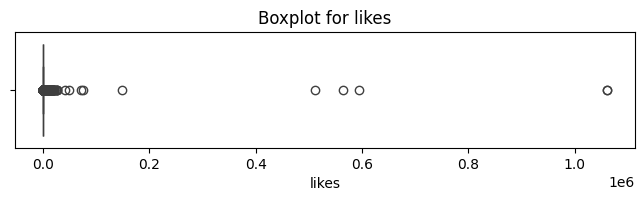

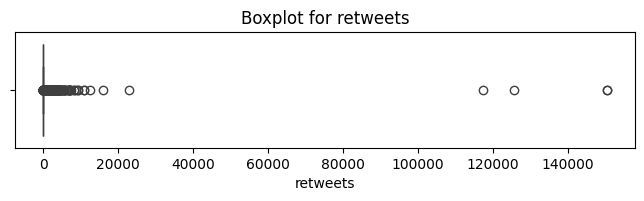

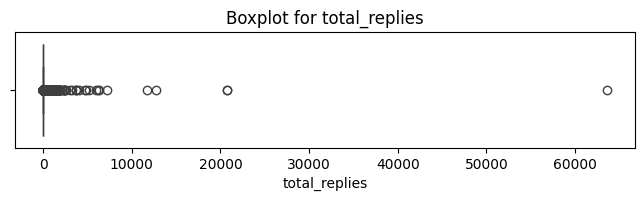

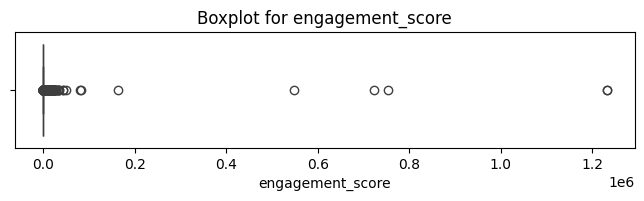

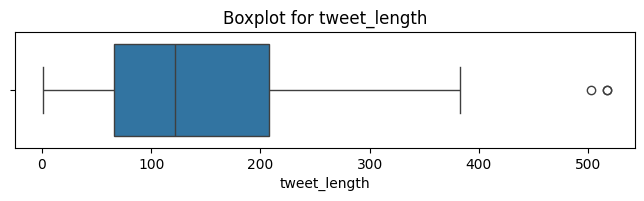

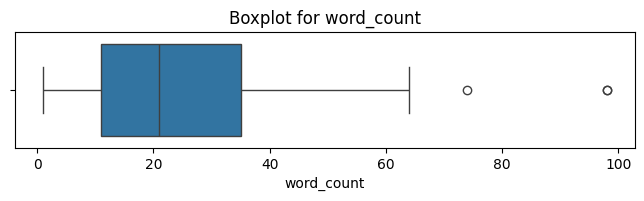

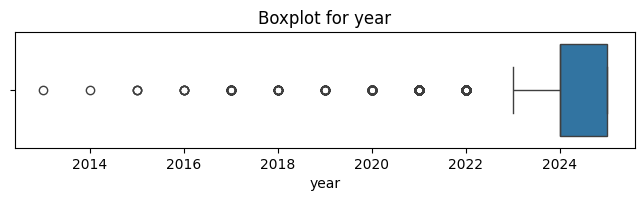

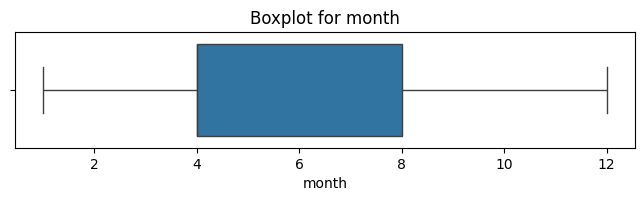

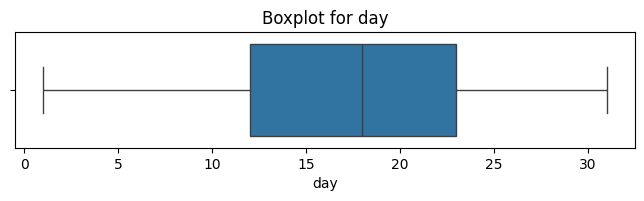

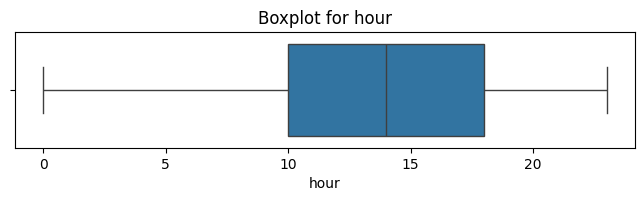

In [33]:
# Select only numeric columns
numeric_cols = ['likes', 'retweets', 'total_replies', 'engagement_score', 
                'tweet_length', 'word_count', 'year', 'month', 'day', 'hour']

for col in numeric_cols:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

## 3.3. Exploratory Data Analysis(EDA)
Bivariate Analysis involves analyzing the relationship between two variables.

### 3.3.1 Tweet Volume by Engagement

In [34]:
# Convert 'created_at' to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Group data by date
df['date'] = df['created_at'].dt.date

# Calculate Tweet Volume and Engagement
tweet_volume = df.groupby('date')['cleaned_text'].count()
engagement = df.groupby('date')['likes'].sum() + df.groupby('date')['retweets'].sum() + df.groupby('date')['total_replies'].sum()

### 3.3.2 Engagement Score vs Hour / Day / Month

See when tweets get the most traction.

#### 1. Engagement Score vs Hour of Day

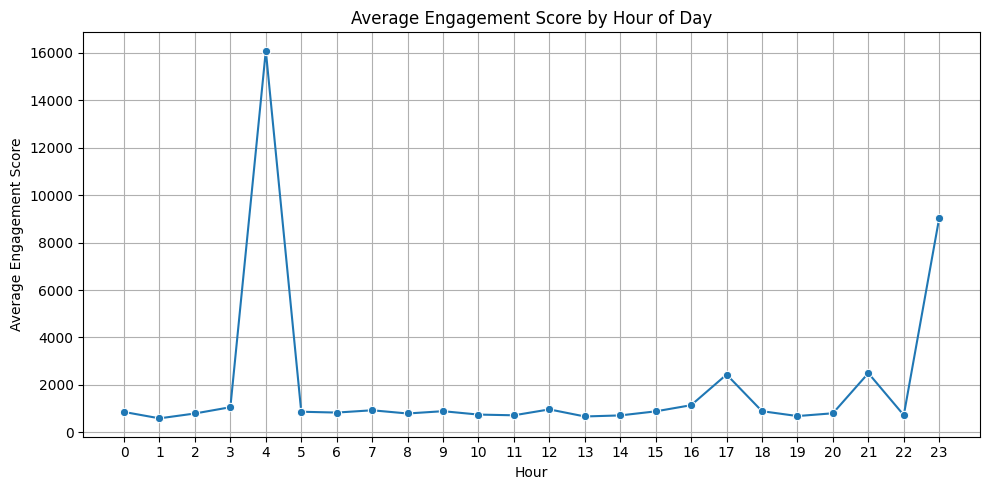

In [35]:
# Group and average engagement score by hour
hourly_engagement = df.groupby('hour')['engagement_score'].mean()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_engagement.index, y=hourly_engagement.values, marker='o')
plt.title('Average Engagement Score by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Engagement Score')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

#### 2. Engagement Score vs Month

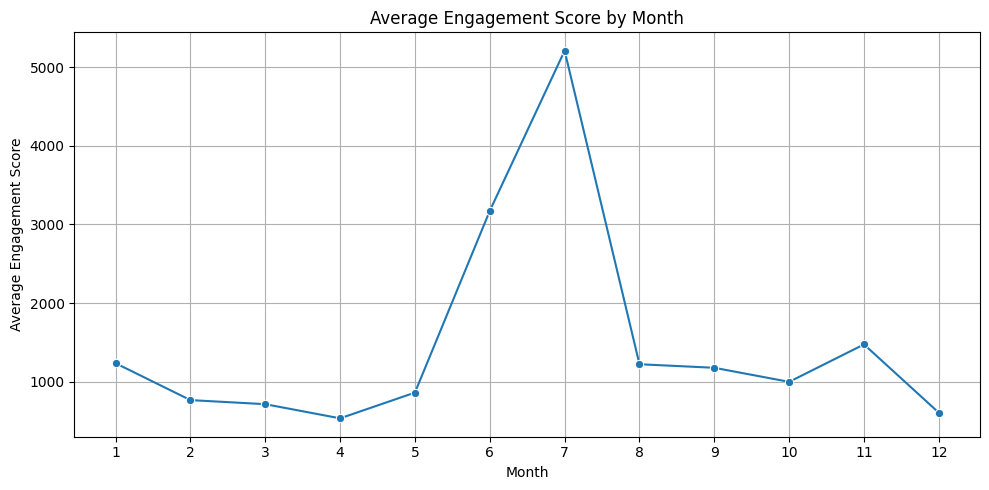

In [36]:
# Group by month
monthly_engagement = df.groupby('month')['engagement_score'].mean()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_engagement.index, y=monthly_engagement.values, marker='o')
plt.title('Average Engagement Score by Month')
plt.xlabel('Month')
plt.ylabel('Average Engagement Score')
plt.grid(True)
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

#### Engagement Score vs Holiday Name

- Do people engage more during specific holidays?

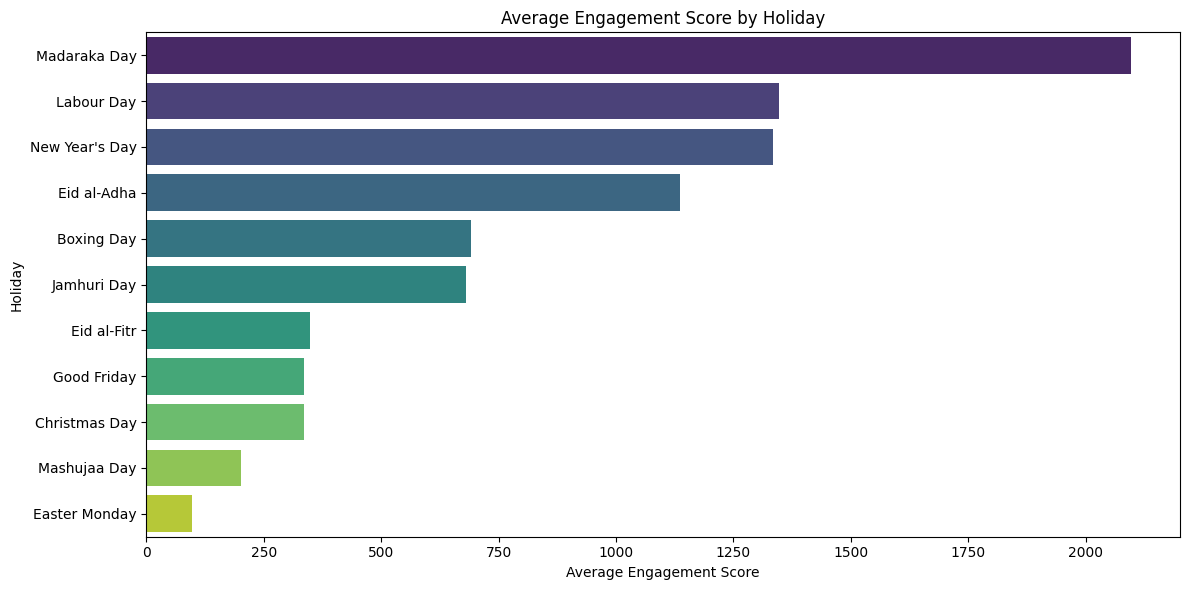

In [37]:
# Filter out non-holiday rows (if holidays are labeled as empty string or NaN)
holiday_df = df[df['holiday_name'].notnull() & (df['holiday_name'] != '')]

# Group by holiday and calculate average engagement
holiday_engagement = holiday_df.groupby('holiday_name')['engagement_score'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=holiday_engagement.values, y=holiday_engagement.index, palette='viridis')
plt.title('Average Engagement Score by Holiday')
plt.xlabel('Average Engagement Score')
plt.ylabel('Holiday')
plt.tight_layout()
plt.show()

### 3.3.3 Engagement Breakdown
**Likes / Retweets / Replies vs Label**

- Are negative tweets more likely to be retweeted?

- Do positive tweets get more likes?

- Are replies more common on neutral tweets?

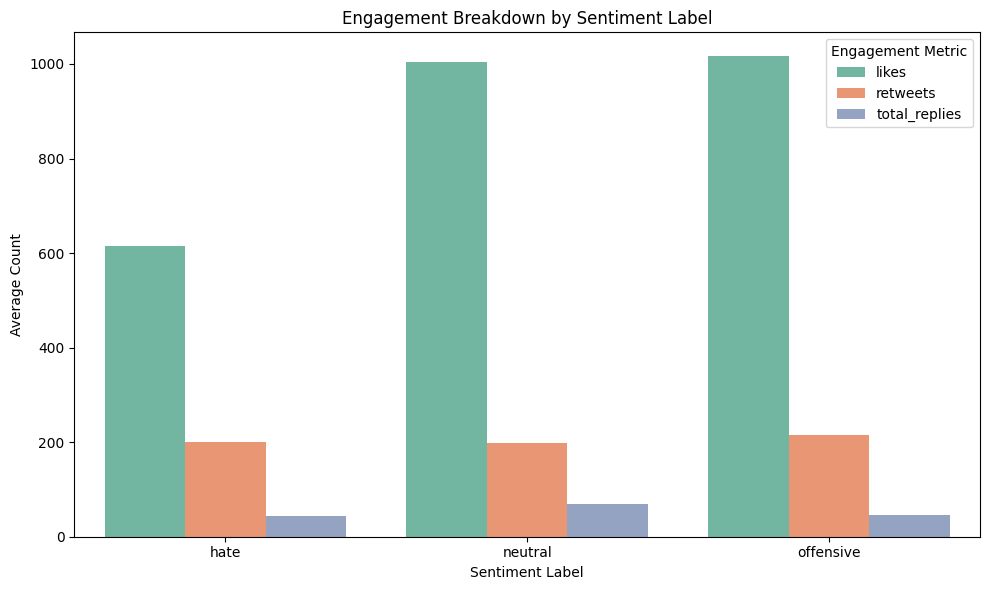

In [38]:
# Group by sentiment label and calculate average likes, retweets, and replies
engagement_metrics = df.groupby('label')[['likes', 'retweets', 'total_replies']].mean().reset_index()

# Melt for seaborn compatibility
engagement_melted = engagement_metrics.melt(id_vars='label', 
                                             value_vars=['likes', 'retweets', 'total_replies'],
                                             var_name='Metric', value_name='Average Count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=engagement_melted, x='label', y='Average Count', hue='Metric', palette='Set2')
plt.title('Engagement Breakdown by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Average Count')
plt.legend(title='Engagement Metric')
plt.tight_layout()
plt.show()

#### Likes / Retweets vs Time Features (hour, day, month)

Understand timing of virality.

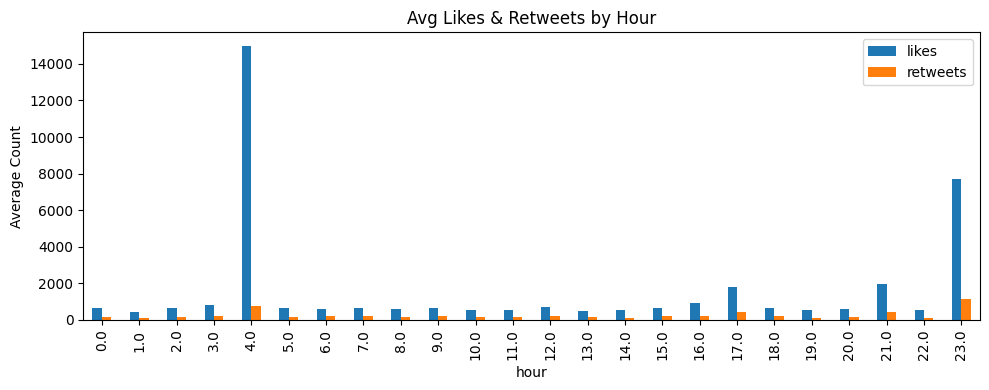

In [39]:
# Likes & Retweets by Hour
df.groupby('hour')[['likes', 'retweets']].mean().plot(kind='bar', figsize=(10, 4))
plt.title('Avg Likes & Retweets by Hour')
plt.ylabel('Average Count')
plt.tight_layout()
plt.show()

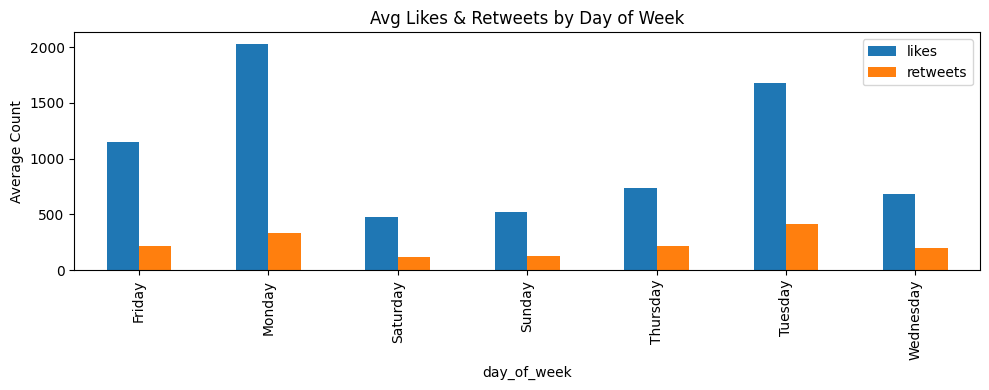

In [40]:
# Likes & Retweets by Day of Week
df.groupby('day_of_week')[['likes', 'retweets']].mean().plot(kind='bar', figsize=(10, 4))
plt.title('Avg Likes & Retweets by Day of Week')
plt.ylabel('Average Count')
plt.tight_layout()
plt.show()

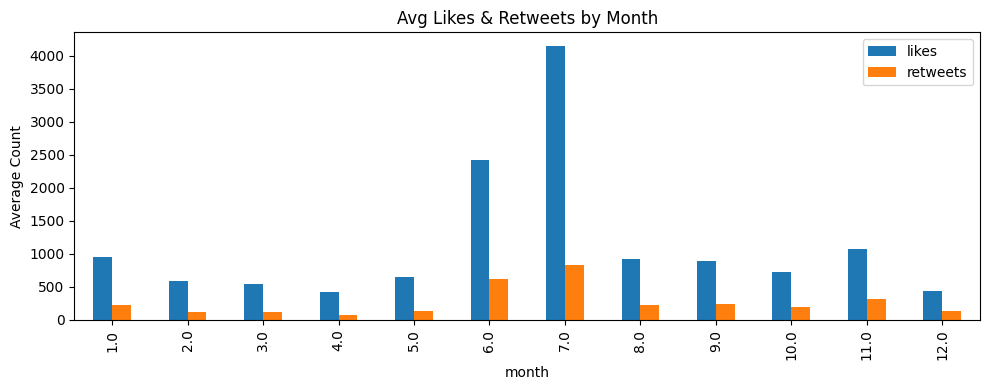

In [41]:
# Likes & Retweets by Month
df.groupby('month')[['likes', 'retweets']].mean().plot(kind='bar', figsize=(10, 4))
plt.title('Avg Likes & Retweets by Month')
plt.ylabel('Average Count')
plt.tight_layout()
plt.show()

### 3.3.4 Entity Involvement

#### Tweet Volume by Political Label

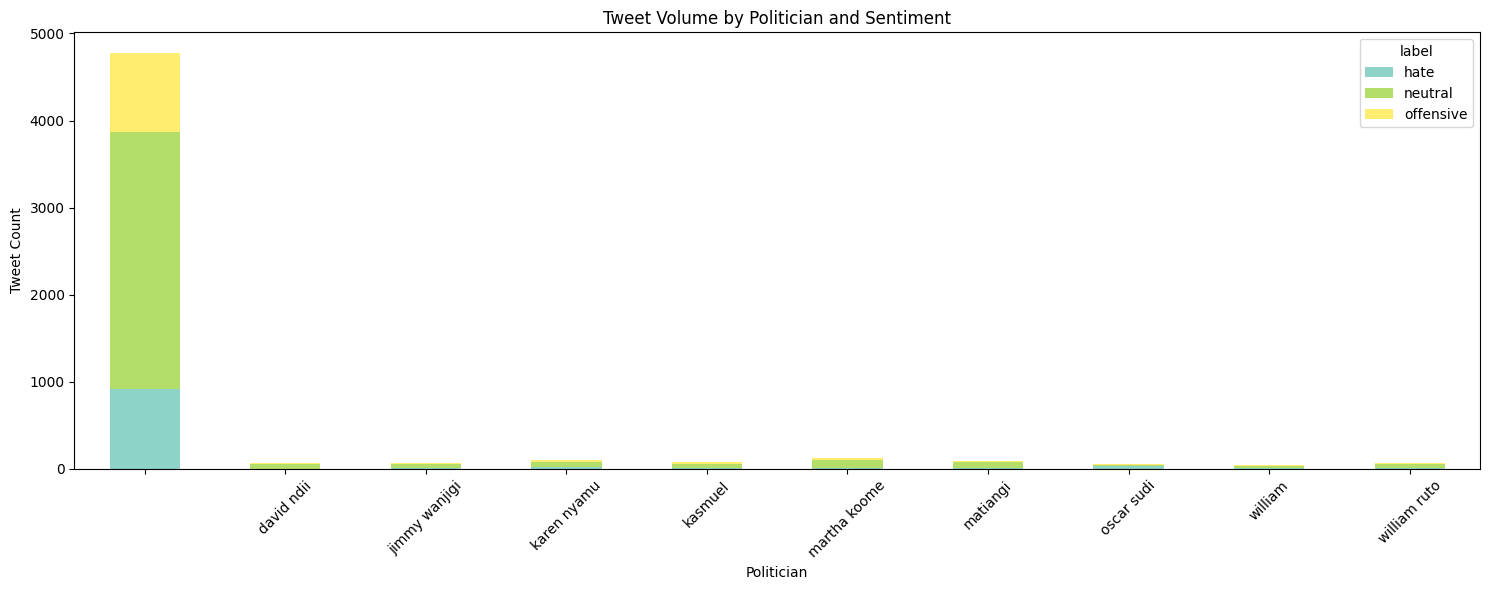

In [42]:
from collections import Counter
import matplotlib.pyplot as plt

# Step 1: Explode the 'entities' list so each person appears on its own row
df_exploded = df.explode('entities')
df_exploded = df_exploded.dropna(subset=['entities'])

# Step 2: Count the most mentioned people/entities
top_10_politicians = df_exploded['entities'].value_counts().head(10).index.tolist()

# Step 3: Filter to only include rows where entity is one of the top 10
df_top = df_exploded[df_exploded['entities'].isin(top_10_politicians)]

# Step 4: Create pivot table grouped by person and sentiment label
pivot_df = df_top.groupby(['entities', 'label']).size().unstack(fill_value=0)

# Step 5: Plot
pivot_df.plot(kind='bar', stacked=True, figsize=(15,6), colormap='Set3')
plt.title('Tweet Volume by Politician and Sentiment')
plt.xlabel('Politician')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Engagement Score vs Politician

Which politicians trigger more public interaction?

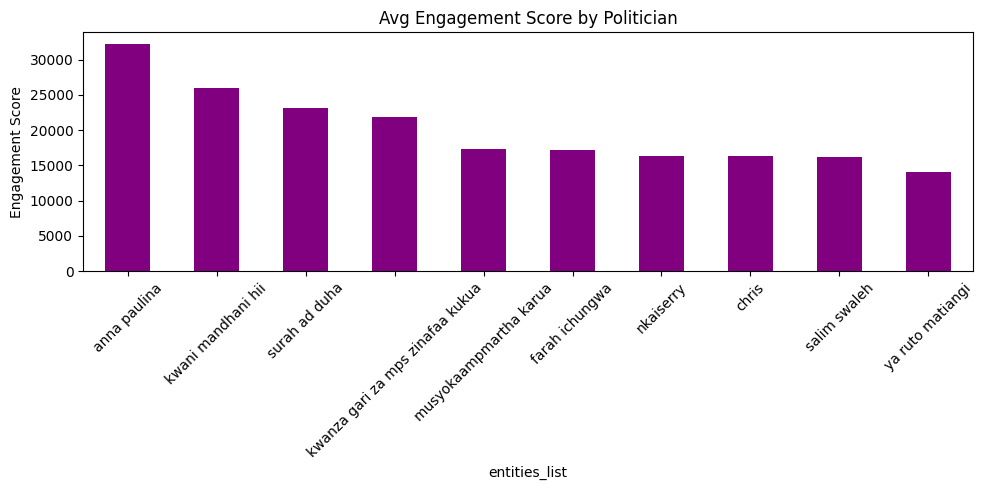

In [43]:
# Ensure 'entities' column is clean and split
df['entities'] = df['entities'].fillna('')
df['entities_list'] = df['entities'].str.lower().str.split(',')

# Explode to have one row per politician mention
df_exploded = df.explode('entities_list')
df_exploded['entities_list'] = df_exploded['entities_list'].str.strip()

# Group and get average engagement score per politician
engagement_by_politician = df_exploded.groupby('entities_list')['engagement_score'].mean().sort_values(ascending=False).head(10)

# Plot
engagement_by_politician.plot(kind='bar', figsize=(10,5), color='purple')
plt.title('Avg Engagement Score by Politician')
plt.ylabel('Engagement Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.3.4 Sentiment / Hate Label vs Time / Activity

#### Label vs Hour / Day / Month

When is hate speech most likely?

Plot: Heatmap

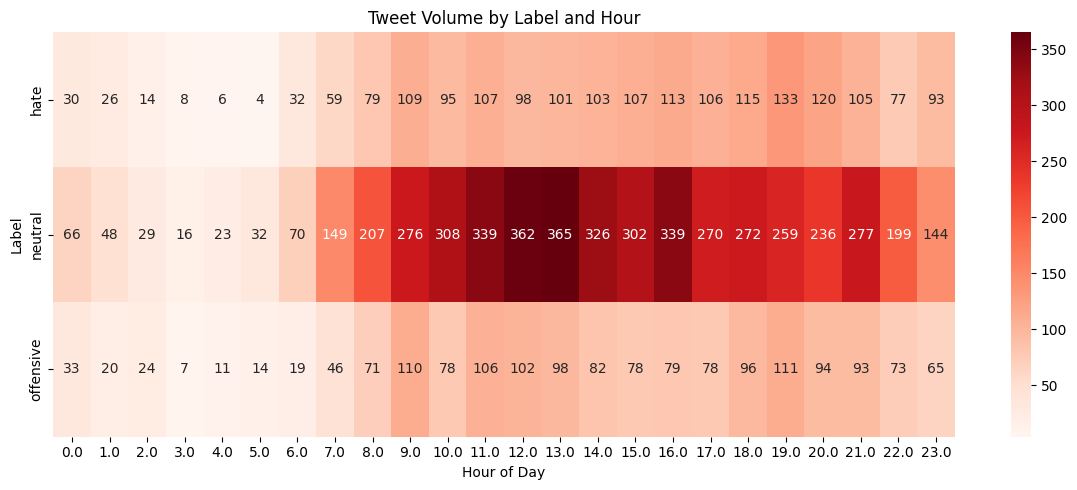

In [44]:
# Create a pivot table: count of tweets by label and hour
heatmap_data = df.pivot_table(index='label', columns='hour', values='cleaned_text', aggfunc='count', fill_value=0)

# Plot
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='d')
plt.title('Tweet Volume by Label and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

#### Label vs Holiday

Is hate speech more or less common on holidays?

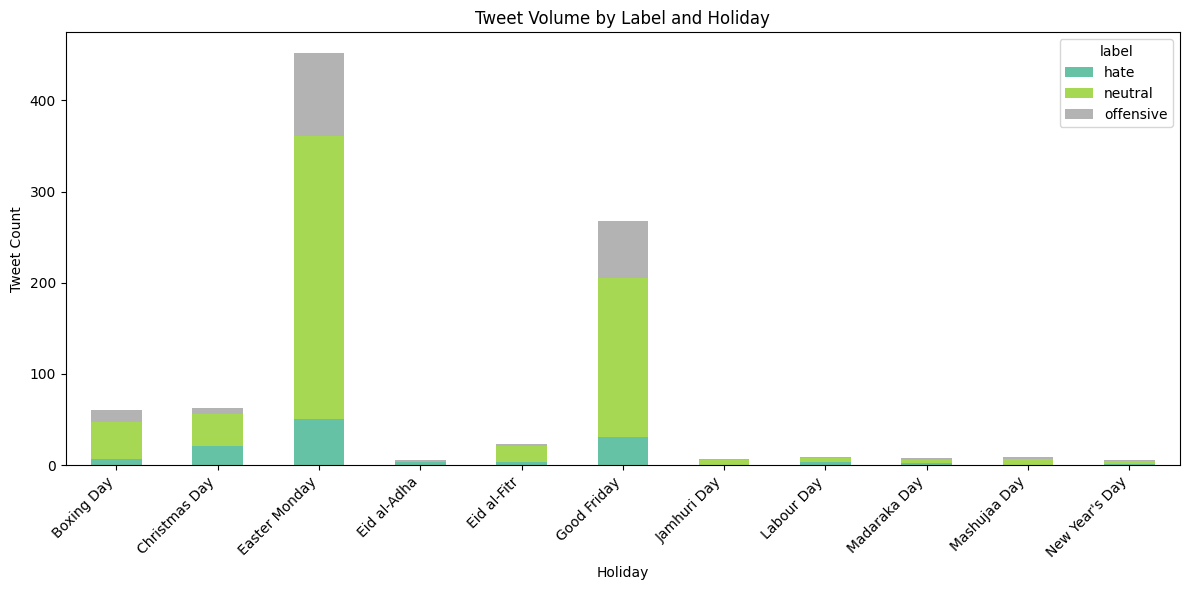

In [45]:
# Count tweets by label and holiday name
label_holiday_counts = df.groupby(['holiday_name', 'label']).size().unstack().fillna(0)

# Plot
label_holiday_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')
plt.title('Tweet Volume by Label and Holiday')
plt.xlabel('Holiday')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#### Tweet Volume by Sentiment

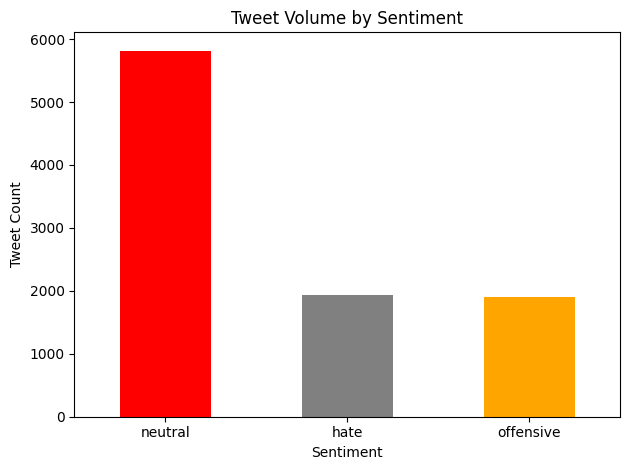

In [46]:
# Count tweets per sentiment
df['label'].value_counts().plot(kind='bar', title='Tweet Volume by Sentiment', color=['red', 'gray', 'orange'])
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [47]:
df['label'].value_counts()

label
neutral      5816
hate         1941
offensive    1907
Name: count, dtype: int64

In [48]:
df['label'].value_counts(normalize=True) * 100

label
neutral      60.182119
hate         20.084851
offensive    19.733030
Name: proportion, dtype: float64